# Import Modules

In [1]:
import torch
import torch.nn as nn
from torchinfo import summary

# VGG

## VGG16 Classification Model for ISL

In [2]:
#Building Model: ISL Classification Model
class Sign_Lang_VGG(torch.nn.Module):
  '''
  Built a VGG16 architecture variant for  Indian Sign Language Classification
  The dataset: https://www.kaggle.com/datasets/prathumarikeri/indian-sign-language-isl
  '''
  def __init__(self,
               input_shape: int,
               output_shape: int):
    super().__init__()
    self.convolutional_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=64,
                  kernel_size=(3,3),
                  stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=(3,3),
                  stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))

    )
    self.convolutional_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=(3,3),
                  stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,
                out_channels=128,
                kernel_size=(3,3),
                stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    self.convolutional_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=128,
                  out_channels=256,
                  kernel_size=(3,3),
                  stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256,
                out_channels=256,
                kernel_size=(3,3),
                stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256,
        out_channels=256,
        kernel_size=(3,3),
        stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    self.convolutional_block_4 = nn.Sequential(
        nn.Conv2d(in_channels=256,
                  out_channels=512,
                  kernel_size=(3,3),
                  stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,
                out_channels=512,
                kernel_size=(3,3),
                stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,
        out_channels=512,
        kernel_size=(3,3),
        stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    self.convolutional_block_5 = nn.Sequential(
        nn.Conv2d(in_channels=512,
                  out_channels=512,
                  kernel_size=(3,3),
                  stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,
                out_channels=512,
                kernel_size=(3,3),
                stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,
        out_channels=512,
        kernel_size=(3,3),
        stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512*4*4,
                  1000),
        nn.ReLU(),
        nn.Linear(1000,
                  1000),
        nn.ReLU(),
        nn.Linear(1000,
                  output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.convolutional_block_1(x)
    x = self.convolutional_block_2(x)
    x = self.convolutional_block_3(x)
    x = self.convolutional_block_4(x)
    x = self.convolutional_block_5(x)
    x = self.classifier(x)
    return x

seed = 25
torch.manual_seed(seed)
model= Sign_Lang_VGG(input_shape=3,
                  output_shape=26)
print(f"{model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Sign_Lang_VGG(
  (convolutional_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (convolutional_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_s

## VGG16

In [ ]:
VGG16 = [64, 64, "MaxPool", 128, 128, "MaxPool", 256, 256, 256, "MaxPool", 512, 512, 512, "MaxPool", 512, 512, 512, "MaxPool"]

class VGG(nn.Module):
    def __init__(self, input=3, output_shape=1000):
        super(VGG, self).__init__()
        self.input = input
        self.convolutional_blocks = self.create_convolutional_blocks(VGG16)

        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, output_shape)
        )
    
    def forward(self, out):
        out = self.convolutional_blocks(out)
        out = self.classifier(out)
        return out
    
    def create_convolutional_blocks(self, architecture):
        layers = []
        input = self.input

        for k in architecture:
            if type(k) == int:
                output = k

                layers += [nn.Conv2d(input, output, 
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                     nn.ReLU()]
                input = k
            elif k == "MaxPool":
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        return nn.Sequential(*layers)



## FSL VGG13

In [27]:
chosen_model_params = [32, 32, "MaxPool", 64, 64, "MaxPool", 128, 128, 128,"MaxPool", 256, 256, 256, "MaxPool"]

class VGG(nn.Module):
    def __init__(self, input=3, output_shape=1000):
        super(VGG, self).__init__()
        self.input = input
        self.convolutional_blocks = self.create_convolutional_blocks(chosen_model_params)

        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(256*2*2, 2096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2096, 2096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2096, output_shape)
        )
    
    def forward(self, out):
        out = self.convolutional_blocks(out)
        # print(f"Shape after convolutional blocks: {out.shape}") ### --> print this to get proper shape for the fully connected layer
        out = self.classifier(out)
        return out
    
    def create_convolutional_blocks(self, architecture):
        layers = []
        input = self.input

        for k in architecture:
            if type(k) == int:
                output = k

                layers += [nn.Conv2d(input, output, 
                                     kernel_size=(5,5), stride=(1,1), padding=(1,1)),
                                     nn.BatchNorm2d(k),
                                     nn.ReLU()]
                input = k
            elif k == "MaxPool":
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        return nn.Sequential(*layers)


seed = 25
torch.manual_seed(25)
# fsl_model = VGG(input=3, output_shape=len(train_data.classes)).to(device)
fsl_model = VGG(input=3, output_shape=26)
print(f"{fsl_model}")



# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


VGG(
  (convolutional_blocks): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(5, 5), 

# Residual Neural Networks

## ResNet50

In [3]:
class Block(nn.Module):
    expansion: int = 4
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(1,1), stride=(1,1), padding=0)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output, kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output)
        self.conv3 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(1,1), stride=(1,1), padding=0)
        self.bn3 = nn.BatchNorm2d(output*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet, self).__init__()
        self.input = 64
        self.conv1 = nn.Conv2d(input_shape, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=64, stride=(1,1))
        self.layer2 = self.make_layer(block,layers[1], output=128, stride=(1,1))
        self.layer3 = self.make_layer(block,layers[2], output=256, stride=(1,1))
        self.layer4 = self.make_layer(block,layers[3], output=512, stride=(1,1))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(512*block.expansion, output_shape)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*4)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for i in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)


seed = 25
torch.manual_seed(25)
model2 = ResNet(Block, [3,4,6,3], input_shape=1, output_shape=17)
print(f"{model2}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model2.parameters())
print(f"Total number of parameters: {total_params}")


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum

## ResNet18

In [28]:
class Block(nn.Module):

    expansion: int = 2

    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output,output*self.expansion, kernel_size=(3,3), stride=stride, padding=(1,1))
        self.bn2 = nn.BatchNorm2d(output*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        # print(f"{self.expansion}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet, self).__init__()
        self.input = 16
        self.conv1 = nn.Conv2d(input_shape, 16, kernel_size=(3,3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=1, padding=0)

        self.layer1 = self.create_layers(block, layers[0], output=16, stride=1)
        self.layer2 = self.create_layers(block, layers[1], output=32, stride=2)
        self.layer3 = self.create_layers(block, layers[2], output=64, stride=2)
        self.layer4 = self.create_layers(block, layers[3], output=128, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential( 
            nn.Flatten(start_dim=1),
            nn.Linear(128 * block.expansion, output_shape)
        )
        # print(f"{block.expansion}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x

    def create_layers(self, block, num_residual_blocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output * block.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output * block.expansion)
            )

        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output * block.expansion

        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)
  

seed = 25
torch.manual_seed(25)
model2 = ResNet(Block, [2,2,2,2], input_shape=1, output_shape=17)
print(f"{model2}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model2.parameters())
print(f"Total number of parameters: {total_params}")


ResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
import torch
import torch.nn as nn

class Block(nn.Module):

    expansion: int = 2

    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output,output*self.expansion, kernel_size=(3,3), stride=stride, padding=(1,1))
        self.bn2 = nn.BatchNorm2d(output*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class Baybayin_ResNet(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(Baybayin_ResNet, self).__init__()
        self.input = 16
        self.conv1 = nn.Conv2d(input_shape, 16, kernel_size=(3,3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=1, padding=0)

        self.layer1 = self.create_layers(block, layers[0], output=16, stride=1)
        self.layer2 = self.create_layers(block, layers[1], output=32, stride=2)
        self.layer3 = self.create_layers(block, layers[2], output=64, stride=2)
        self.layer4 = self.create_layers(block, layers[3], output=128, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential( 
            nn.Flatten(start_dim=1),
            nn.Linear(128 * block.expansion, output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x

    def create_layers(self, block, num_residual_blocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output * block.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.input, output * block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output * block.expansion)
            )

        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output * block.expansion

        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)
  

def ResNet18(img_channels=1, output_shape=10):
    return ResNet(Block, [2, 2, 2, 2], img_channels, output_shape)

# Example usage:
model = ResNet18()
print(model)

ResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

FSL ResNet34

In [2]:
class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet, self).__init__()
        self.input = 32
        self.conv1 = nn.Conv2d(input_shape, 32, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=32, stride=(1,1))
        self.layer2 = self.make_layer(block,layers[1], output=64, stride=(2,2))
        self.layer3 = self.make_layer(block,layers[2], output=128, stride=(2,2))
        self.layer4 = self.make_layer(block,layers[3], output=256, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(256*block.expansion, output_shape)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for i in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)


seed = 25
torch.manual_seed(25)
# fsl_model = ResNet(Block, [3,4,6,3], input_shape=3, output_shape=26).to(device)
fsl_model = ResNet(Block, [3,4,6,3], input_shape=3, output_shape=26)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), paddin

# Helper codes F1, Recall, Precision, and Confusion Matrix

In [ ]:
from torchmetrics.classification import ConfusionMatrix
from torchmetrics.functional import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def infer(data_loader:torch.utils.data.DataLoader,
           model:torch.nn.Module,
           test_data):
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Send the data to the proper target device
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_logit = model(X)
            # Turn predictions into class labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())

    # Concatenate list of predictions into a tensor
    y_preds = torch.cat(y_preds)  # This line ensures y_preds is a tensor

    # Ensure test_data.targets is a tensor
    test_targets_tensor = torch.tensor(test_data.targets) if not isinstance(test_data.targets, torch.Tensor) else test_data.targets
    return test_targets_tensor, y_preds

test_targets1, y_preds1 = infer(test_dataloader, model_LION, test_data)

def create_confusion_matrix(y_true, y_pred, class_names, num_classes=None, figsize=(19, 10)):

    if num_classes is None:
        num_classes = len(class_names)
    
    # Create confusion matrix instance
    confmat = ConfusionMatrix(num_classes=num_classes, task="multiclass")
    confmat_tensor = confmat(preds=y_pred, target=y_true)
    
    # Plot confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=figsize
    )
    plt.show()
    
    return confmat_tensor

create_confusion_matrix(test_targets1, y_preds1, class_names=train_data.classes)
f1_score1, precision_score1, recall_score1 = calculate_metric(test_targets1.cpu(), y_preds1)
print(f"Print F1 score: {f1_score1}")
print(f"Precision Score: {precision_score1}")
print(f"Recall Score: {recall_score1}")


# Metrics

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
def calculate_metric(y_true, y_pred, average="weighted"): ##--> Choose 'micro', 'macro', or 'weighted'
    # Convert logits to predicted class labels if necessary
    if y_pred.dim() > 1:
        y_pred = torch.argmax(y_pred, dim=1)

    # Move to CPU and convert to numpy arrays if necessary
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average=average)  
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    
    return f1, precision, recall

# CNN KAN

Convolutional Neural Network Kolgomorov Arnold Network

## VGG_KAN

In [ ]:
# chosen_model_params = [32, 32, "MaxPool", 64, 64, "MaxPool", 128, 128, 128,"MaxPool", 256, 256, 256, "MaxPool"]
chosen_model_params = [64, "MaxPool",128, 128, "MaxPool"]
# chosen_model_params = [16,16,"MaxPool",32,"Maxpool"]

class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32)) #adjusted during training
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize)) #adjusted during training
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x): #Combines cosine/sine terms with learnable coefficents for Fourier expansion and sums them + bias
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class VGG_KAN(nn.Module):
    def __init__(self, input=3, output_shape=26):
        super(VGG_KAN, self).__init__()
        self.input = input
        self.convolutional_blocks = self.create_convolutional_blocks(chosen_model_params)

        self.KANClassifier = nn.Sequential(
            NaiveFourierKANLayer(128*3*3, 256, initial_gridsize=30),
            NaiveFourierKANLayer(256, output_shape, initial_gridsize=25)

        )
    
    def forward(self, out):
        out = self.convolutional_blocks(out)
        # print(f"Shape after convolutional blocks: {out.shape}") ### --> print this to get proper shape for the fully connected layer

        # out = self.classifier(out)
        out = out.view(out.size(0), -1)
        out = self.KANClassifier(out)
        return out
    
    def create_convolutional_blocks(self, architecture):
        layers = []
        input = self.input

        for k in architecture:
            if type(k) == int:
                output = k

                layers += [nn.Conv2d(input, output, 
                                     kernel_size=(3,3), stride=(2,2), padding=(1,1)),
                                     nn.BatchNorm2d(k),
                                     nn.SELU()]
                input = k
            elif k == "MaxPool":
                layers += [nn.MaxPool2d(kernel_size=(4,4), stride=(2,2))]
        return nn.Sequential(*layers)
    

torch.manual_seed(42)
fsl_model = VGG_KAN(input=3, output_shape=26)
print(f"{fsl_model}")



# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


VGG_KAN(
  (convolutional_blocks): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): MaxPool2d(kernel_size=(4, 4), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SELU()
    (10): MaxPool2d(kernel_size=(4, 4), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (KANClassifier): Sequential(
    (0): NaiveFourierKANLayer()
    (1): NaiveFourierKANLayer()
  )
)
Total number of parameters: 15302556


### Dummy Data

In [4]:
tensor1 = torch.randn(size=(3, 128, 128))  # Single image (C, H, W)
print(tensor1.shape) 

output = fsl_model(tensor1.unsqueeze(dim=0))  # Add batch dimension
print(output)

torch.Size([3, 128, 128])
Shape after convolutional blocks: torch.Size([1, 256, 7, 7])
tensor([[-0.0244,  0.1089, -0.3710, -0.1900, -0.3575, -0.3632,  0.3811, -0.0240,
         -0.0849, -0.0614,  0.0439, -0.0904, -0.1795, -0.0823,  0.0301,  0.2366,
          0.3434,  0.1383,  0.1374,  0.2822,  0.1175,  0.0741,  0.1067, -0.1370,
          0.1333, -0.2222]], grad_fn=<ViewBackward0>)


## ResNet KAN

In [34]:
import numpy as np
import torch
import torch.nn as nn

class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32)) #adjusted during training
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))
            nn.init.kaiming_normal_(self.bias)

    def forward(self, x): #Combines cosine/sine terms with learnable coefficents for Fourier expansion and sums them + bias
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet_KAN(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet_KAN, self).__init__()
        self.input = 32
        self.conv1 = nn.Conv2d(input_shape, 32, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=32, stride=(1,1))
        self.layer2 = self.make_layer(block,layers[1], output=64, stride=(2,2))
        self.layer3 = self.make_layer(block,layers[2], output=128, stride=(2,2))
        self.layer4 = self.make_layer(block,layers[3], output=256, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.KANClassifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            NaiveFourierKANLayer(256*block.expansion, 512, initial_gridsize=50),
            NaiveFourierKANLayer(512, output_shape, initial_gridsize=50)

        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = self.KANClassifier(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for i in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)



seed = 42
torch.manual_seed(23)
fsl_model = ResNet_KAN(Block, [2,2,2,2], input_shape=3, 
                       output_shape=26)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


ResNet_KAN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), pa

### View initialization for ResNet KAN

In [107]:
for name, param in fsl_model.named_parameters():
  if "fouriercoeffs" in name:
    print(f"Layer: {name}, Fourier Coefficients:\n{param.data}\n")
  # if "weight" in name:
  #   print(f"Layer: {name}:, Weights: {param.data}")
  elif "bias" in name:
    print(f"Layer: {name}, Biases: {param.data}")

Layer: conv1.bias, Biases: tensor([-0.0781, -0.1030,  0.0394,  0.0026,  0.1062, -0.0296, -0.0620, -0.0299,
        -0.0952,  0.0856, -0.0479,  0.0041, -0.0407, -0.0992,  0.0846,  0.1045,
         0.0254, -0.0170,  0.1145,  0.0511,  0.0584,  0.0230,  0.1045, -0.0673,
         0.0402,  0.0710, -0.0604, -0.0720, -0.0469, -0.0301,  0.0789,  0.0958])
Layer: bn1.bias, Biases: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
Layer: layer1.0.conv1.bias, Biases: tensor([-0.0253, -0.0417,  0.0310, -0.0109,  0.0068, -0.0416, -0.0042,  0.0353,
        -0.0095,  0.0414,  0.0152, -0.0585,  0.0407, -0.0427,  0.0546, -0.0252,
        -0.0504, -0.0239,  0.0060,  0.0002, -0.0388,  0.0135, -0.0153,  0.0252,
        -0.0422,  0.0571,  0.0250, -0.0188,  0.0241,  0.0499,  0.0254,  0.0565])
Layer: layer1.0.bn1.bias, Biases: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [124]:
tensor1 = torch.randn(size=(3, 128, 128))  # Single image (C, H, W)
print(tensor1.shape)

output = fsl_model(tensor1.unsqueeze(dim=0))  # Add batch dimension
print(output)

torch.Size([3, 128, 128])
tensor([[ 0.2318,  0.0547,  0.6426, -0.0577, -0.4347, -0.6254,  0.0017, -0.1285,
         -0.3610,  0.3880,  0.3038, -0.2632, -0.0245,  0.8562,  0.0191, -0.2727,
         -0.2240,  0.4684, -0.0673, -0.1873,  0.2119, -0.1177, -0.5432,  0.2457,
          0.1707,  0.0375]], grad_fn=<ViewBackward0>)


In [43]:
for name, param in fsl_model.named_parameters():
    if param.requires_grad:  # Ensures we only inspect trainable parameters
        if "fouriercoeffs" in name:
            print(f"Layer: {name}, Fourier Coefficients:\n{param.data}\n")
        # elif "bias" in name:
        #     print(f"Layer: {name}, Biases:\n{param.data}\n")
        # elif "weight" in name:
        #     print(f"Layer: {name}, Weights:\n{param.data}\n")


Layer: KANClassifier.1.fouriercoeffs, Fourier Coefficients:
tensor([[[[-3.4559e-03, -2.1262e-02, -9.9435e-03,  ...,  1.6428e-02,
            4.7876e-03,  9.2377e-03],
          [-1.2113e-02, -1.9879e-02,  6.0552e-03,  ..., -1.0994e-02,
           -9.2924e-03, -9.6265e-03],
          [-3.7348e-03, -8.3083e-03,  9.9061e-04,  ..., -8.4609e-04,
           -1.7406e-02, -1.5949e-03],
          ...,
          [ 1.8264e-03,  1.5777e-03, -1.9887e-03,  ...,  1.3169e-03,
            1.2873e-02,  6.6389e-03],
          [-8.6265e-04,  6.7001e-04, -1.5453e-02,  ...,  1.8155e-02,
            2.4868e-03, -6.7170e-03],
          [ 1.8978e-03,  4.0801e-03, -5.2635e-03,  ...,  1.5672e-02,
           -1.3830e-02,  6.7259e-03]],

         [[-4.9398e-03,  1.3222e-03, -1.7405e-02,  ..., -4.0871e-03,
           -1.2426e-02,  4.2763e-03],
          [-5.5842e-03, -1.0265e-02,  1.2770e-02,  ...,  4.6642e-03,
           -1.5909e-02,  1.4144e-02],
          [ 6.1552e-03,  1.3524e-02,  4.9043e-03,  ..., -3.9339e-03

In [48]:
import numpy as np
import torch
import torch.nn as nn

class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32)) #adjusted during training
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))
            nn.init.kaiming_normal_(self.bias)

    def forward(self, x): #Combines cosine/sine terms with learnable coefficents for Fourier expansion and sums them + bias
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet_KAN(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet_KAN, self).__init__()
        self.input = 32
        self.conv1 = nn.Conv2d(input_shape, 32, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=32, stride=(1,1))
        self.layer2 = self.make_layer(block,layers[1], output=64, stride=(2,2))
        self.layer3 = self.make_layer(block,layers[2], output=128, stride=(2,2))
        self.layer4 = self.make_layer(block,layers[3], output=256, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.KANClassifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(256*block.expansion, 256),
            nn.ReLU(),
            NaiveFourierKANLayer(256, 128, initial_gridsize=30),
            nn.Linear(128, output_shape),
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = self.KANClassifier(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for i in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)


torch.manual_seed(23)
fsl_model = ResNet_KAN(Block, [3,4,3,3], input_shape=3, 
                       output_shape=26)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


ResNet_KAN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), pa

In [36]:
import numpy as np
import torch
import torch.nn as nn

class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32)) #adjusted during training
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))
            nn.init.kaiming_normal_(self.bias)

    def forward(self, x): #Combines cosine/sine terms with learnable coefficents for Fourier expansion and sums them + bias
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet_KAN(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet_KAN, self).__init__()
        self.input = 16
        self.conv1 = nn.Conv2d(input_shape, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=16, stride=(2,2))
        self.layer2 = self.make_layer(block,layers[1], output=32, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.KANClassifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32*block.expansion, 50),  # MLP first
            nn.ReLU(),
            NaiveFourierKANLayer(50, 50, initial_gridsize=10),
            NaiveFourierKANLayer(50, output_shape, initial_gridsize=10)

        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)

        x = self.KANClassifier(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for _ in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)



torch.manual_seed(23)
fsl_model = ResNet_KAN(Block, [2,2,2], input_shape=1, 
                       output_shape=10)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


ResNet_KAN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:
from tqdm.auto import tqdm

#Adan: Adaptive Nesterov Momentum Algorithm (2024)

import math
from typing import List
from torch import Tensor

class MultiTensorApply(object):
    available = False
    warned = False

    def __init__(self, chunk_size):
        try:
            MultiTensorApply.available = True
            self.chunk_size = chunk_size
        except ImportError as err:
            MultiTensorApply.available = False
            MultiTensorApply.import_err = err

    def __call__(self, op, noop_flag_buffer, tensor_lists, *args):
        return op(self.chunk_size, noop_flag_buffer, tensor_lists, *args)


class Adan(torch.optim.Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for
        Faster Optimizing Deep Models[J].arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or
            dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for
            first- and second-order moments. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay
            (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay
            (default: False)
        foreach (bool): if True would use torch._foreach implementation.
            It's faster but uses slightly more memory. (default: True)
        fused (bool, optional): whether fused implementation is used.
            (default: False)
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True,
                 fused: bool = False):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        if fused:
            _check_fused_available()

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach,
                        fused=fused)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same# Since we added LogSoftmax, use NLLLoss instead step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            if not params_with_grad:
                continue

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                if group['fused']:
                    if torch.cuda.is_available():
                        _fused_adan_multi_tensor(**kwargs)
                    else:
                        raise ValueError('Fused Adan does not support CPU')
                else:
                    _multi_tensor_adan(**kwargs)
            elif group['fused']:
                if torch.cuda.is_available():
                    _fused_adan_single_tensor(**kwargs)
                else:
                    raise ValueError('Fused Adan does not support CPU')
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_multi_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    import fused_adan
    multi_tensor_applier = MultiTensorApply(2048 * 32)
    _dummy_overflow_buf = torch.cuda.IntTensor([0])
    multi_tensor_applier(
        fused_adan.adan_multi_tensor, _dummy_overflow_buf,
        [params, grads, exp_avgs, exp_avg_sqs, exp_avg_diffs, neg_pre_grads],
        beta1, beta2, beta3, bias_correction1, bias_correction2,
        bias_correction3_sqrt, lr, weight_decay, eps, no_prox,
        clip_global_grad_norm)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_single_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        p_data_fp32 = param.data.float()
        out_p = param.data
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad = neg_pre_grads[i]
        with torch.cuda.device(param.device):
            import fused_adan
            fused_adan.adan_single_tensor(
                p_data_fp32,
                out_p,
                grad,
                exp_avg,
                exp_avg_sq,
                exp_avg_diff,
                neg_grad,
                beta1,
                beta2,
                beta3,
                bias_correction1,
                bias_correction2,
                bias_correction3_sqrt,
                lr,
                weight_decay,
                eps,
                no_prox,
                clip_global_grad_norm,
            )
        neg_grad.zero_().add_(grad, alpha=-1.0)


def _check_fused_available():
    try:
        import fused_adan
    except ImportError as exc:
        if torch.cuda.is_available():
            # The module should be available but isn't. Try to
            # help the user in this case.
            raise ImportError((
                str(exc)
                + (
                    '\nThis could be caused by not having compiled '
                    'the CUDA extension during package installation. '
                    'Please try to re-install the package with '
                    'the environment flag `FORCE_CUDA=1` set.'
                )
            ))
        else:
            raise ImportError(
                str(exc) + '\nFused Adan does not support CPU.')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2064
Epoch [2/5], Loss: 0.0725
Epoch [3/5], Loss: 0.0598
Epoch [4/5], Loss: 0.0564
Epoch [5/5], Loss: 0.0501


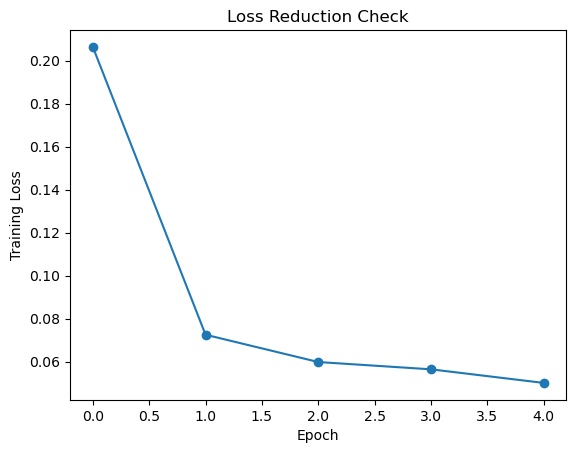

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 📌 1️⃣ Load MNIST Dataset (Grayscale 1-Channel Images)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 📌 2️⃣ Modify Model for MNIST (1-channel input, 10 output classes)
model = ResNet_KAN(Block, layers=[2, 2, 2], input_shape=1, output_shape=10)

# 📌 3️⃣ Define Loss & Optimizer
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = Adan(model.parameters(), lr=0.001, betas=(0.98,0.92,0.99), weight_decay=1e-3)

# 📌 4️⃣ Training Loop
num_epochs = 5
train_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # images, labels = images.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 📌 5️⃣ Plot Loss Curve
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Reduction Check")
plt.show()


# SqueezeNet Implementation

In [ ]:
class fire(torch.nn.Module):
    def __init__(self, inplanes: int , squeeze_planes: int, expand1x1: int, expand3x3: int) -> None:
        super(fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = torch.nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.act1 = torch.nn.ReLU(inplace=True)
        self.expand1x1 = torch.nn.Conv2d(squeeze_planes, expand1x1, kernel_size=1)
        self.expand1x1_act1 = torch.nn.ReLU(inplace=True)
        self.expand3x3 = torch.nn.Conv2d(squeeze_planes, expand3x3, kernel_size=3, stride=1, padding=1)
        self.expand3x3_act1 = torch.nn.ReLU(inplace=True)

        #using the initialization from Guo et al. (2024)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.normal_(m.weight, mean=-1.0, std=0.1)
                if m.bias is not None:
                    torch.nn.init.normal_(m.bias, mean=-1.0, std=0.1)


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.squeeze(x)
        x = self.act1(x)
        output1 = self.expand1x1(x)
        output1 = self.expand1x1_act1(output1)
        output2 = self.expand3x3(x)
        output2 = self.expand3x3_act1(output2)
        final_output = torch.cat((output1, output2), dim=1)
        return final_output

    
class SqueezeNet(torch.nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, kernel_size=7, stride=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            fire(96, 16, 64, 64),
            fire(128, 16, 64, 64),
            fire(128, 32, 128, 128),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            fire(256, 32, 128, 128),
            fire(256, 48, 192, 192),
            fire(384, 48, 192, 192),
            fire(384, 64, 256, 256),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            fire(512, 64, 256, 256)
        )

        final_conv = torch.nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = torch.nn.Sequential(
            final_conv,
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1)),
        )
        #using the initialization from Guo et al. (2024)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.normal_(m.weight, mean=-1.0, std=0.1)
                if m.bias is not None:
                    torch.nn.init.normal_(m.bias, mean=-1.0, std=0.1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        x = torch.flatten(x, 1)
        return x
    


model = SqueezeNet(num_classes=10)

dummy_tensor = torch.randn(1, 3, 32, 224)
model(dummy_tensor)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 740554


## View Initialized weights and biases from $\mathcal{N}(-1, 0.1)$

In [80]:
for name, param in model.named_parameters():
  if "weight" in name:
    print(f"Layer: {name}:, Weights: {param.data}")
  elif "bias" in name:
    print(f"Layer: {name}, Biases: {param.data}")

Layer: features.0.weight:, Weights: tensor([[[[-1.0267, -0.9539, -1.1363,  ..., -1.0701, -1.1500, -1.0902],
          [-0.8397, -0.9701, -0.7909,  ..., -1.0602, -0.8029, -0.9956],
          [-1.1987, -0.8596, -0.7731,  ..., -1.2196, -0.9326, -0.9606],
          ...,
          [-1.0597, -1.0457, -0.8061,  ..., -0.9152, -1.1185, -0.8797],
          [-0.9530, -0.9182, -0.9133,  ..., -0.9913, -1.0417, -1.0573],
          [-0.9832, -0.9007, -0.9920,  ..., -0.8518, -0.9828, -1.1887]],

         [[-1.0452, -0.9763, -1.0186,  ..., -1.0797, -1.1063, -0.9815],
          [-0.9619, -0.9099, -0.9501,  ..., -1.0902, -1.0781, -0.9721],
          [-1.0094, -0.8103, -0.8306,  ..., -1.3008, -1.0814, -0.8515],
          ...,
          [-0.8575, -1.0552, -1.0188,  ..., -1.3010, -1.1293, -0.9776],
          [-0.9676, -1.0298, -0.8153,  ..., -0.9835, -1.1222, -1.0616],
          [-1.0942, -1.0845, -0.8839,  ..., -1.2025, -1.0950, -1.0736]],

         [[-0.7113, -0.8566, -1.1176,  ..., -0.9065, -0.7872, -1.0